In [269]:
import cv2
import PIL
import random
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pdb

from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.nn.functional import binary_cross_entropy_with_logits
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

from fastai.vision.data import SegmentationItemList, SegmentationLabelList, ImageList
from fastai.data_block import FloatList, FloatItem
from fastai.vision.image import Image, ImageSegment, image2np, pil2tensor
from fastai.vision.transform import get_transforms
from fastai.vision.learner import unet_learner, cnn_learner
import fastai.vision.models as mod
from fastai.callbacks import SaveModelCallback
from fastai.metrics import accuracy

from pathlib import Path

# IMAGE SIZES
TRAIN_SIZE = 256
MAX_SIZE = 1388
TEST_SIZE = 224
TEST_OVERLAP = 64
IMG_CHANNELS = 3

# PATHS
PROJECT_PATH = Path(
    '/work/stages/schwob/siim-pneumothorax')
FULL_TRAIN_PATH = PROJECT_PATH/'data/dicom-images-train'
FULL_TEST_PATH = PROJECT_PATH/'data/dicom-images-test'
TRAIN_PATH = PROJECT_PATH/'data/train'
TEST_PATH = PROJECT_PATH/'data/test'
MODELS_PATH = PROJECT_PATH/'models/'
SUB_PATH = PROJECT_PATH/'submissions/'
LABELS_OLD = PROJECT_PATH/'data/train-rle.csv'
LABELS = PROJECT_PATH/'data/train-rle-fastai1.csv'
LABELS_CLASSIF = PROJECT_PATH/'data/train-rle-fastai-classif.csv'
LOG = Path('/work/stages/schwob/runs')

# LEARNER CONFIG
BATCH_SIZE = 4
WD = 0.1
LR = 1e-2
GROUP_LIMITS = None
FREEZE_UNTIL = None
EPOCHS = 10
UNFROZE_EPOCHS = 10
PRETRAINED = True
MODEL = 'resnet34'
CLASSES = ['pneum']
ACT = 'sigmoid'

In [244]:
models = {
    'resnet34': mod.resnet34, 'resnet50': mod.resnet50,
    'resnet101': mod.resnet101, 'resnet125': mod.resnet152}

In [3]:
def restruct(src, dest):
    for fn in src.glob('**/*dcm'):
        ds = pydicom.dcmread(str(fn))
        pydicom.dcmwrite(str(dest/fn.name), ds)

In [4]:
#restruct(FULL_TRAIN_PATH, TRAIN_PATH)

In [5]:
#restruct(FULL_TEST_PATH, TEST_PATH)

In [6]:
def change_csv(old, new, path):
    df = pd.read_csv(old, sep=', ')
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for row in df.itertuples():
        image_id = row.ImageId
        label = row.EncodedPixels
        image_id = Path(path.name)/(image_id+'.dcm')
        new_df.loc[row.Index] = [image_id, label]
    new_df.to_csv(new, index=False)

In [7]:
#change_csv(LABELS_OLD, LABELS, TRAIN_PATH)

In [110]:
df = pd.read_csv(LABELS, header='infer')
df.head()

,ImageId,EncodedPixels
0,train/1.2.276.0.7230010.3.1.4.8323329.5597.151...,-1
1,train/1.2.276.0.7230010.3.1.4.8323329.12515.15...,-1
2,train/1.2.276.0.7230010.3.1.4.8323329.4904.151...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,train/1.2.276.0.7230010.3.1.4.8323329.32579.15...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,train/1.2.276.0.7230010.3.1.4.8323329.1314.151...,119331 47 972 82 937 107 912 122 897 137 882 1...


In [70]:
df.shape

(11582, 2)

In [69]:
df['ImageId'].unique().shape

(10675,)

In [105]:
def merge_doubles(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for k, id in enumerate(df['ImageId'].unique()):
        rles = []
        for rle in df.loc[df['ImageId']==id, 'EncodedPixels']:
            rles.append(rle)
        new_df.loc[k] = [id, ' '.join(rles)]
    new_df.to_csv(new, index=False)

In [141]:
def create_classif_csv(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'Labels'])
    for row in df.itertuples():
        image_id = row.ImageId
        rle = row.EncodedPixels
        new_df.loc[row.Index] = [image_id, 1 if rle!='-1' else 0]
    new_df.to_csv(new, index=False)

In [143]:
create_classif_csv(LABELS, LABELS_CLASSIF)

In [75]:
def open_image(fn):
    return pydicom.dcmread(str(fn)).pixel_array

def show(img, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.bone)
    plt.show()

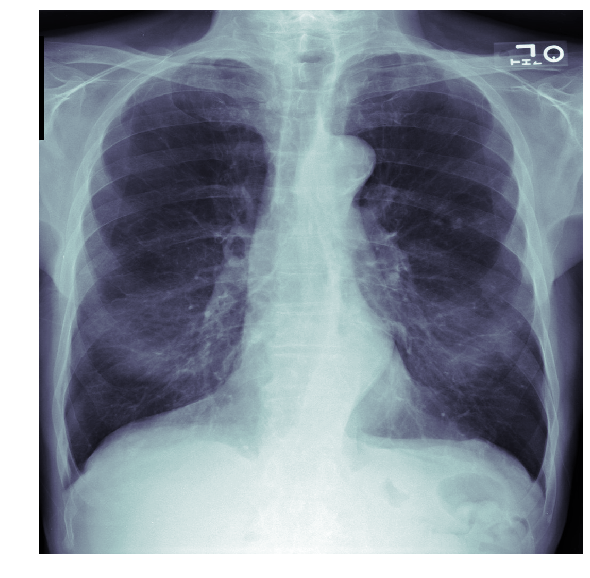

In [76]:
fn = next(TRAIN_PATH.glob('**/*.dcm'))
img = open_image(fn)
show(img)

In [77]:
img.shape

(1024, 1024)

In [78]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel += 1

    return " ".join(rle)

In [79]:
def rle2mask(rle, width, height):
    if rle == '-1':
        return np.zeros((width, height))
    mask = np.zeros(width * height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height).T

In [80]:
class PneumoSegmentationList(SegmentationItemList):
    def open(self, fn):
        x = open_image(fn)
        x = pil2tensor(x, np.float32)
        x = torch.cat((x, x, x))
        return Image(x/255)

In [81]:
class ImageSegmentFloat(ImageSegment):
    @property
    def data(self):
        return self.px.float()

In [82]:
class MaskList(SegmentationLabelList):
    def __init__(self, *args, train_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_path = train_path
        
    def open(self, fn):
        assert self.train_path, "a path for train set must be specified"
        img_path = fn[0]
        rle = fn[1]
        h, w = open_image(self.train_path/img_path).shape
        y = rle2mask(rle, w, h)
        y = pil2tensor(y, np.float32)
        return ImageSegmentFloat(y/255)
    
    def analyze_pred(self, pred, thresh: float = 0.5):
        return (pred > thresh).float()
    
    def reconstruct(self, t):
        return ImageSegmentFloat(t.float())

In [85]:
class PneumoClassifList(ImageList):
    def open(self, fn):
        x = open_image(fn)
        x = pil2tensor(x, np.float32)
        x = torch.cat((x, x, x))
        return Image(x/255)

In [230]:
class WeightList:
    def __init__(self, counter, classes=[]):
        assert isinstance(classes, list), "classes must be lists"
        self._counter = counter
        self._classes = classes
        
    def __len__(self):
        return len(self._classes)
    
    def __getitem__(self, key):
        return self._counter[self._classes[key]]
    
    def __iter__(self):
        return iter([self._counter[c] for c in self._classes])
        
    def append(self, c):
        self._classes.append(c)
        
    def pop(self, key):
        self._classes.pop(key)
        
    def increment(self, c):
        self._counter[c] += 1
        
    def inverse(self):
        self._counter = 1/self._counter
        
    def tolist(self):
        return [self._counter[c] for c in self._classes]

In [277]:
def create_sampler(train_list):
    weights = WeightList(np.zeros(train_list.c), classes=[])
    for _, c in tqdm(train_list.train):
        weights.increment(c.data)
        weights.append(c.data)
    weights.inverse()
    sampler = WeightedRandomSampler(weights.tolist(), len(weights))
    return sampler

In [133]:
def load_data(path, bs=8, train_size=256):
    train_list = (PneumoSegmentationList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df(cols=[0, 1], classes=['pneum'], label_cls=MaskList, train_path=path.parent).
                  transform(get_transforms(), size=train_size, tfm_y=True).
                  databunch(bs=bs, num_workers=0))
    return train_list

In [250]:
def load_data_classif(path, bs=8, train_size=256, weight_sample=True):
    train_list = (PneumoClassifList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df().
                  transform(get_transforms(), size=train_size))
    if weight_sample:
        sampler = create_sampler(train_list)
    train_list = train_list.databunch(bs=bs, num_workers=0).normalize()
    if weight_sample:
        train_list.train_dl = train_list.train_dl.new(shuffle=False, sampler=sampler)
    return train_list

In [92]:
db = load_data(LABELS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)

In [93]:
db.train_ds[0][1].px

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

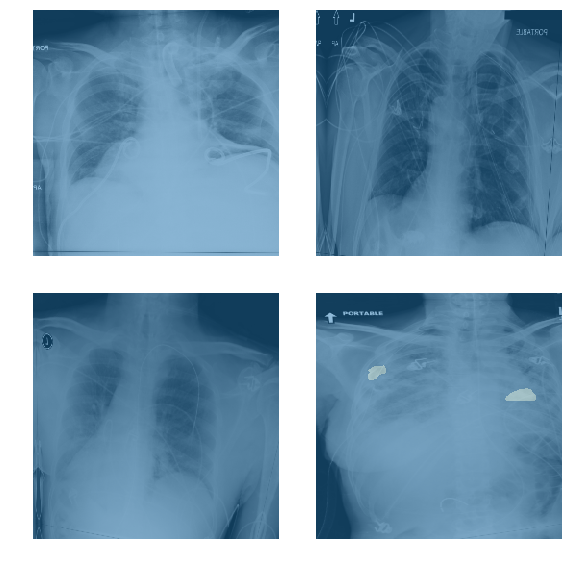

In [104]:
db.show_batch(cmap=plt.cm.bone)

In [41]:
def dice(input, target, smooth=1.):
    iflat = torch.sigmoid(input).view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return (2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)

In [50]:
def dice_loss(input, target, smooth=1e-2):
    return 1-dice(input, target, smooth=smooth)

In [51]:
def bce_dice_loss(input, target, a=0.5, b=0.5, smooth=1.):
    return a*dice_loss(input, target, smooth=smooth)+b*binary_cross_entropy_with_logits(input, target)

In [52]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, input, target):
        return dice_loss(input, target, smooth=self.smooth)

In [53]:
class BCEDiceLoss(nn.Module):
    def __init__(self, a=0.5, b=0.5, smooth=1.):
        super().__init__()
        self.a = a
        self.b = b
        self.smooth = smooth
        
    def forward(self, input, target):
        return bce_dice_loss(input, target, a=self.a, b=self.b, smooth=self.smooth)

In [54]:
learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED, loss_func=DiceLoss(), wd=WD, model_dir=MODELS_PATH, metrics=[dice])

In [55]:
learner.lr_find(num_it=2000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


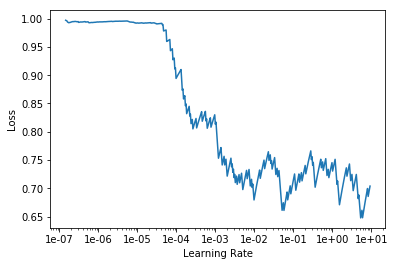

In [48]:
learner.recorder.plot(skip_end=1)

In [57]:
learner.fit_one_cycle(
    10, slice(LR),
    callbacks=[
        SaveModelCallback(
            learner, monitor='dice', name='first_test')])

epoch,train_loss,valid_loss,dice,time
0,0.787499,0.753941,0.246059,10:14
1,0.810877,0.753941,0.246059,09:55
2,0.716555,0.753941,0.246059,10:04
3,0.746631,0.753941,0.246059,10:10
4,0.689200,0.753941,0.246059,09:56
5,0.737468,0.753941,0.246059,10:11
6,0.792321,0.753941,0.246059,09:51
7,0.770028,0.753941,0.246059,10:01


Better model found at epoch 0 with dice value: 0.24605929851531982.


KeyboardInterrupt: 

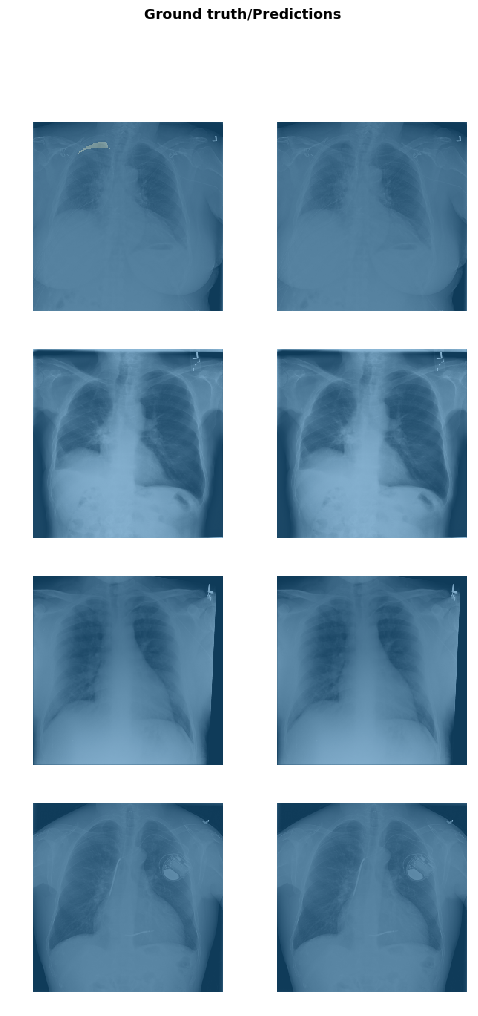

In [58]:
learner.show_results()

In [64]:
learner.unfreeze()

In [62]:
learner.lr_find(num_it=2000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


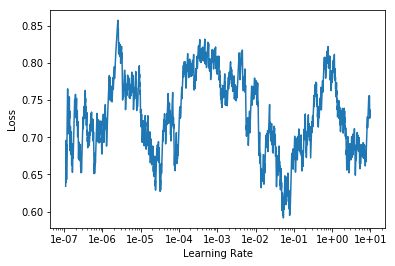

In [63]:
learner.recorder.plot(skip_end=1)

In [66]:
learner.fit_one_cycle(
    10, slice(1e-2),
    callbacks=[
        SaveModelCallback(
            learner, monitor='dice', name='first_test_unfrozen')])

epoch,train_loss,valid_loss,dice,time
0,0.771628,0.753941,0.246059,10:29
1,0.777179,0.753941,0.246059,10:29


Better model found at epoch 0 with dice value: 0.24605929851531982.


KeyboardInterrupt: 

In [117]:
X, y_true = db.train_ds[10]

In [129]:
_, _, y_pred = learner.predict(X)

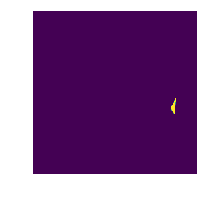

In [119]:
y_true.show()

In [275]:
db_clf = load_data_classif(LABELS_CLASSIF, bs=BATCH_SIZE, train_size=TRAIN_SIZE, weight_sample=True)

> <ipython-input-274-e6941492c253>(8)create_sampler()
-> sampler = WeightedRandomSampler(weights.tolist(), len(weights))
(Pdb) c


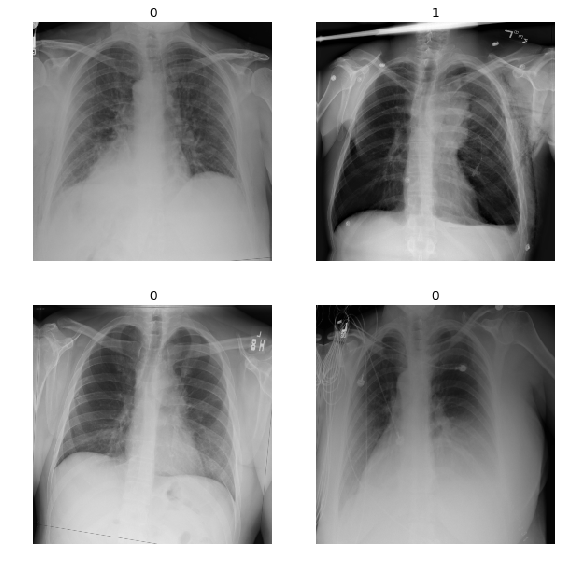

In [279]:
db_clf.show_batch(cmap=plt.cm.bone)

In [237]:
clf = cnn_learner(db_clf, models["resnet101"], pretrained=PRETRAINED, loss_func=nn.CrossEntropyLoss(), wd=WD, model_dir=MODELS_PATH, metrics=[accuracy])

In [181]:
clf.unfreeze()

In [182]:
clf.lr_find(num_it=1000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


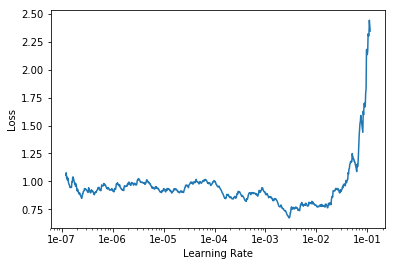

In [183]:
clf.recorder.plot()

In [ ]:
clf.fit_one_cycle(
    50, slice(1e-3),
    callbacks=[
        SaveModelCallback(
            clf, monitor='accuracy', name='first_test_clf')])

epoch,train_loss,valid_loss,accuracy,time


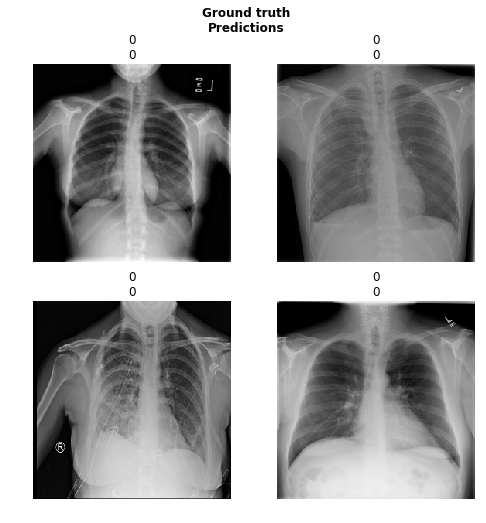

In [239]:
clf.show_results()

In [240]:
interp = clf.interpret()

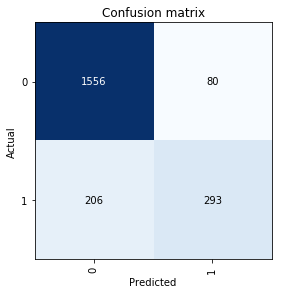

In [241]:
interp.plot_confusion_matrix()

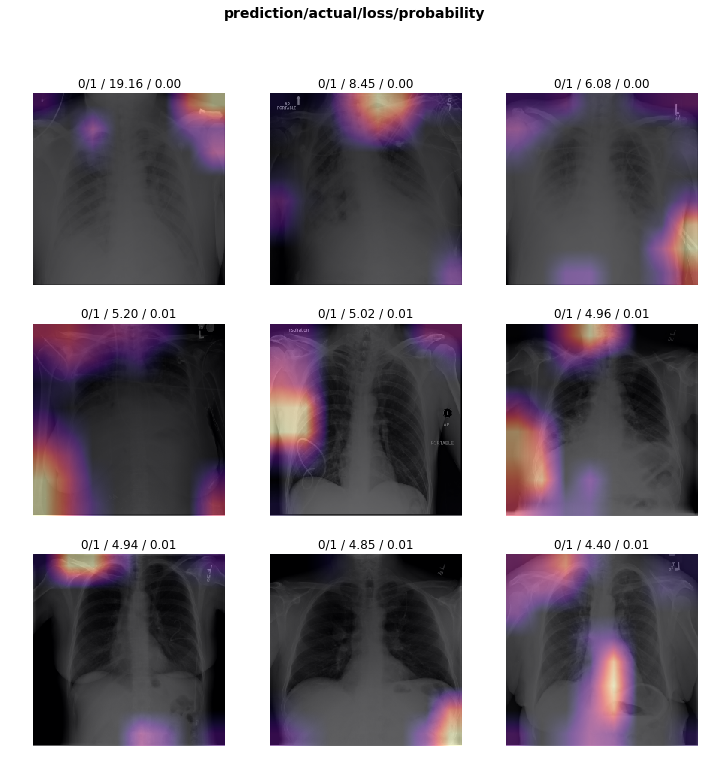

In [242]:
interp.plot_top_losses(9)

In [247]:
import matplotlib.pyplot as plt

In [248]:
plt.cm.bone

AttributeError: train